# 0. Описание задачи

Для освоения методов машинного обучения будем использовать базу данных интернет-магазина Sephora - ритейлера косметики и уходовых средств сегментов миддл и люкс. Будем пытаться предсказать рейтинг товара (задача восстановления регрессии) на основе цены, ингредиентов и других признаков. В датасете изначально 21 признак, но не все они влияют на рейтинг продукта (из личного опыта):

* category - категория на сайте
* brand - марка продукта 
* rating - средняя оценка пользователей (от 0 до 5 с шагом 0.5)
* love - сколько раз добавили в список желаемого
* price - цена (в долларах США)
* ingredients - состав
* limited_edition - ограниченный тираж
* limited_time_offer - доступно для покупки в течение ограниченного времени


Эти признаки необходимо оставить, так как они напрямую влияют на рейтинг продукта. Состав - текстовый признак, и его нельзя разбить на категории, так как количество возможных ингредиентов очень большое, и ключевую роль играют далеко не все компоненты. Поэтому попробуем выделить из каждого состава важнейшие ингредиенты и сделать уже их категориальными признаками. 


* name - название производителя
* ID - ID продукта на сайте 
* number of reviews - количество оценок
* value_price - цена с учетом скидки
* URL - ссылка на страницу продукта
* MarketingFlags - флаг для признаков exclusive, online_only
* MarketingFlags_content
* options - можно ли выбрать оттенок и так далее
* details - доступные детали
* how_to_use - инструкция
* online_only - можно купить только через сайт
* exclusive - можно купить только в этом магазине

Эти же признаки не должны оказывать сильного влияния на рейтинг продукта


# 1. и 2. Исходные данные и описательная статистика

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Исходный датафрейм

In [2]:
url = 'sephora_website_dataset.csv'
data = pd.read_csv(url)
data.tail()

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
9163,2208502,SEPHORA COLLECTION,Face Masks,The Rose Gold Mask,no size,2.0,15,6200,6.0,6.0,...,True,limited edition · exclusive,no options,What it is: A limited-edition- nurturing and h...,Suggested Usage:-Unfold the mask.-Apply the ma...,-Rose Quartz Extract: Hydrates dry skin. Aqua...,0,1,1,0
9164,2298909,SEPHORA COLLECTION,Lip Sets,Give Me Some Sugar Colorful Gloss Balm Set,3 x 0.32 oz/ 9 g,0.0,0,266,15.0,27.0,...,True,exclusive,no options,What it is: A set of three bestselling Colorfu...,Suggested Usage:-Apply directly to lips using ...,Colorful Gloss Balm Wanderlust: Hydrogenated P...,0,1,0,0
9165,2236750,SEPHORA COLLECTION,Tinted Moisturizer,Weekend Warrior Tone Up Cream,0.946 oz/ 28 mL,0.0,0,445,16.0,16.0,...,True,exclusive,no options,What it is: A weightless complexion booster- i...,Suggested Usage:-Use this product as the last ...,Aqua (Water)- Dimethicone- Isohexadecane- Poly...,0,1,0,0
9166,50,SEPHORA COLLECTION,no category,Gift Card,no size,5.0,46,0,50.0,50.0,...,False,0,no options,What it is:- Available in denominations of $10...,no instructions,unknown,0,0,0,0
9167,304,SEPHORA COLLECTION,no category,Happy Birthday Gift Card,no size,0.0,0,0,50.0,50.0,...,False,0,no options,What it is:\r\n- Available in denominations of...,no instructions,unknown,0,0,0,0


Информация о данных:

In [3]:
data.describe()

,id,rating,number_of_reviews,love,price,value_price,online_only,exclusive,limited_edition,limited_time_offer
count,9.168000e+03,9168.000000,9168.000000,9.168000e+03,9168.000000,9168.00000,9168.000000,9168.000000,9168.000000,9168.000000
mean,1.962952e+06,3.990020,282.139180,1.627859e+04,50.063237,51.82359,0.234839,0.264725,0.091841,0.000327
std,3.859714e+05,1.007707,890.642028,4.260651e+04,47.164989,49.45902,0.423921,0.441211,0.288817,0.018087
min,5.000000e+01,0.000000,0.000000,0.000000e+00,2.000000,2.00000,0.000000,0.000000,0.000000,0.000000
25%,1.819453e+06,4.000000,10.000000,1.600000e+03,24.000000,25.00000,0.000000,0.000000,0.000000,0.000000
50%,2.072354e+06,4.000000,46.000000,4.800000e+03,35.000000,35.00000,0.000000,0.000000,0.000000,0.000000
75%,2.230591e+06,4.500000,210.000000,1.380000e+04,59.000000,60.00000,0.000000,1.000000,0.000000,0.000000
max,2.359685e+06,5.000000,19000.000000,1.300000e+06,549.000000,549.00000,1.000000,1.000000,1.000000,1.000000


Средний рейтинг - 4, средняя цена - 50 долларов, минимальная - 2, максимальная - 5 

Матрица корреляции:

<AxesSubplot:>

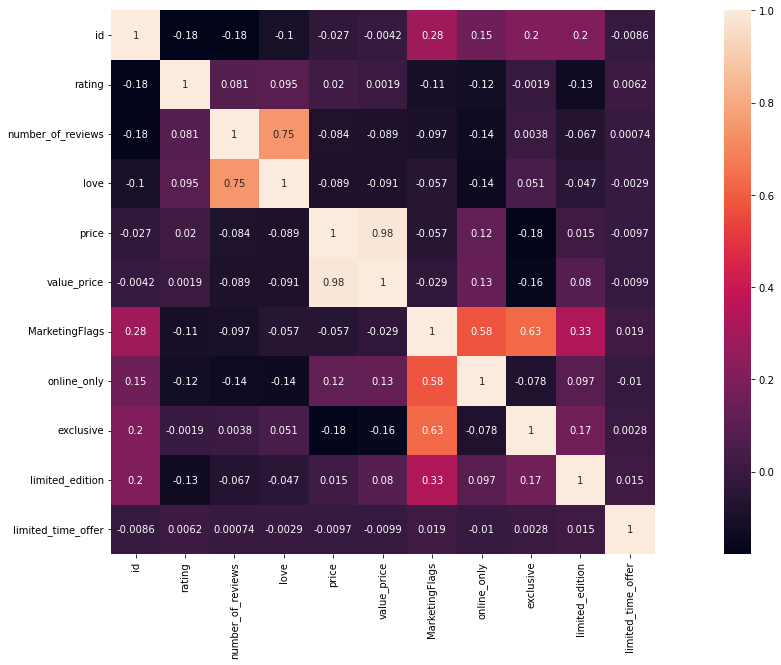

In [4]:
correlation = data.corr()
plt.figure(figsize=(25, 10))
sns.heatmap(correlation, square=True, annot=True, cmap='rocket')

Сильной корреляции почти не наблюдается - только у признаков MarketingFlag и признаков, соответствующих этому индикатору, а также у цены и той же цены с учетом скидки. У рейтинга слабая корреляция со всеми признаками

Диаграммы рассеивания для некоторых признаков

Text(0.5, 1.0, 'Зависимость рейтинга от цены')

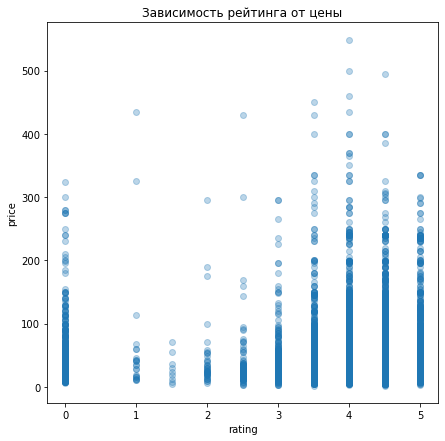

In [5]:
plt.figure(figsize=(7, 7))
plt.scatter(data['rating'], data['price'], alpha = 0.3, )
plt.xlabel('rating')
plt.ylabel('price')
plt.title('Зависимость рейтинга от цены')

Ситуация понятная - у многих продуктов еще просто нет рейтинга, никто их не оценивал. Преобладают оценки 3 и выше, ожидаемо для косметики среднего и выше ценового сегмента.

Text(0.5, 1.0, 'Зависимость количества людей, добавивших товар в список желаемого, от цены')

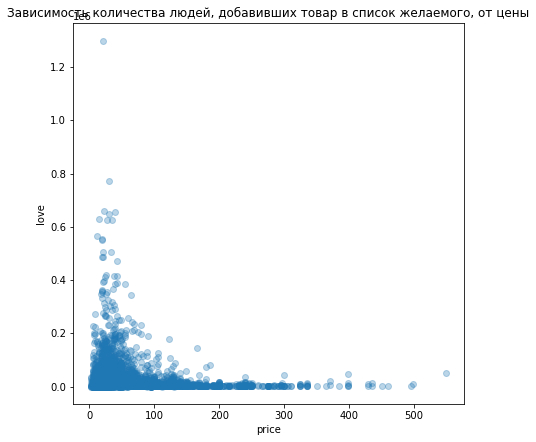

In [6]:
plt.figure(figsize=(7, 7))
plt.scatter(data['price'], data['love'], alpha = 0.3, )
plt.xlabel('price')
plt.ylabel('love')
plt.title('Зависимость количества людей, добавивших товар в список желаемого, от цены')

Чем дешевле товар, тем он популярнее в качестве планируемой покупки, также заметен выброс в левом верхнем углу диаграммы.

Text(0.5, 1.0, 'Зависимость количества людей, добавивших товар в список желаемого, от рейтинга')

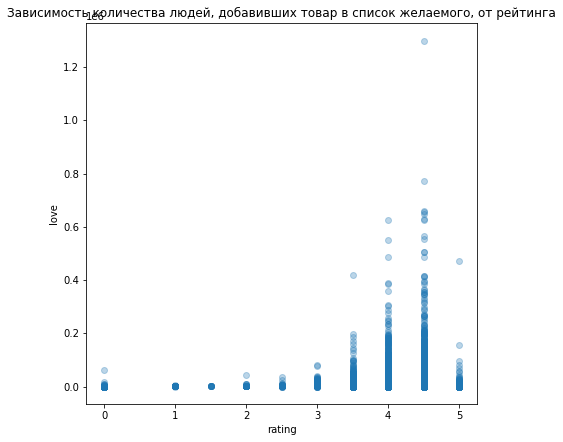

In [7]:
plt.figure(figsize=(7, 7))
plt.scatter(data['rating'], data['love'], alpha = 0.3, )
plt.xlabel('rating')
plt.ylabel('love')
plt.title('Зависимость количества людей, добавивших товар в список желаемого, от рейтинга')

Можно говорить, что покупатели присматриваются к товарам с высокой оценкой.

Text(0.5, 1.0, 'Зависимость числа отзывов от цены')

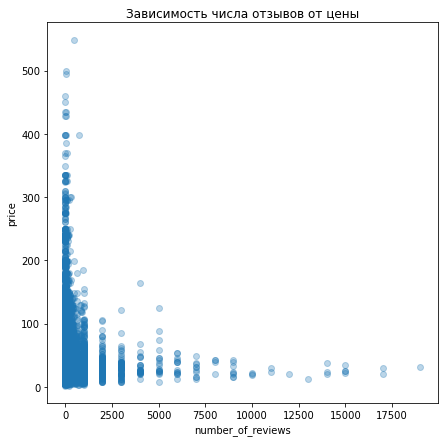

In [8]:
plt.figure(figsize=(7, 7))
plt.scatter(data['number_of_reviews'], data['price'], alpha = 0.3, )
plt.xlabel('number_of_reviews')
plt.ylabel('price')
plt.title('Зависимость числа отзывов от цены')

В среднем оставляют менее 2000 оценок, дорогие продукты оценивают реже (соответственно покупают реже).

# 3. Работа с пропущенными значениями

In [9]:
data.isna().sum()

id                        0
brand                     0
category                  0
name                      0
size                      0
rating                    0
number_of_reviews         0
love                      0
price                     0
value_price               0
URL                       0
MarketingFlags            0
MarketingFlags_content    0
options                   0
details                   0
how_to_use                0
ingredients               0
online_only               0
exclusive                 0
limited_edition           0
limited_time_offer        0
dtype: int64

Пропущенных числовых значений нет. Но есть товары без рейтинга!

In [10]:
Counter(data['rating'])

Counter({4.0: 2853,
         4.5: 3527,
         3.5: 1051,
         5.0: 872,
         3.0: 308,
         0.0: 398,
         2.5: 88,
         2.0: 39,
         1.0: 23,
         1.5: 9})

In [11]:
for i in range(len(data)):
    if data['rating'][i] == 0.0:
        data=data.drop(i, axis=0)
Counter(data['rating'])

Counter({4.0: 2853,
         4.5: 3527,
         3.5: 1051,
         5.0: 872,
         3.0: 308,
         2.5: 88,
         2.0: 39,
         1.0: 23,
         1.5: 9})

In [12]:
data=data.set_index(np.array(range(len(data))))
data

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,True,online only,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,True,online only,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,True,online only,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,True,online only,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,True,online only,no options,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8765,2149847,SEPHORA COLLECTION,Bath Soaks & Bubble Bath,Fizzing Bath Star Mini - Surprise Flowers,0.53oz/15g,3.5,11,2100,2.0,2.0,...,True,exclusive · online only,no options,What it is: A fizzing star that dissolves int...,Suggested Usage:-Place the fizzing star in the...,Sodium Bicarbonate- Citric Acid- CI 77891 (Tit...,1,1,0,0
8766,1601111,SEPHORA COLLECTION,Brush Sets,Face the Day: Full Face Brush Set,no size,3.5,62,32900,49.0,95.0,...,True,limited edition · exclusive,no options,What it is:\r\nA six-piece brush set designed ...,no instructions,unknown,0,1,1,0
8767,2149839,SEPHORA COLLECTION,Scrub & Exfoliants,Exfoliating Body Granita Scrub - Surprise Flowers,8.45oz/250mL,3.5,39,6900,8.0,8.0,...,True,exclusive · online only,no options,What it is: An indulgent- yet gentle exfoliat...,Suggested Usage:-Apply to wet skin.-Massage in...,Water- Glycerin- Cellulose Acetate- Sodium Lau...,1,1,0,0
8768,2208502,SEPHORA COLLECTION,Face Masks,The Rose Gold Mask,no size,2.0,15,6200,6.0,6.0,...,True,limited edition · exclusive,no options,What it is: A limited-edition- nurturing and h...,Suggested Usage:-Unfold the mask.-Apply the ma...,-Rose Quartz Extract: Hydrates dry skin. Aqua...,0,1,1,0


# 4. Обработка категориальных признаков (и всех данных)

Удалим столбцы, не влияющие или слабо влияющие на рейтинг продукта

In [14]:
data = data.drop([
'name',
'id',
'number_of_reviews', #поскольку задача предсказать рейтинг у нового продукта, это ни к чему
'value_price',
'URL',
'MarketingFlags',
'MarketingFlags_content',
'options',
'details',
'how_to_use',
'online_only',
'exclusive', 'size'], axis = 1)

In [15]:
brands = dict(Counter(data['brand']))
brands

{'Acqua Di Parma': 29,
 'AERIN': 21,
 'Aether Beauty': 6,
 'Algenist': 51,
 'Alpha-H': 13,
 'alpyn beauty': 5,
 'ALTERNA Haircare': 42,
 'amika': 63,
 'AMOREPACIFIC': 31,
 'Anastasia Beverly Hills': 68,
 'Anthony': 14,
 'Antonym': 3,
 'Aquis': 5,
 'Armani Beauty': 55,
 'The Art of Shaving': 15,
 'Artis': 19,
 'Artist Couture': 8,
 'Atelier Cologne': 44,
 'BALENCIAGA': 2,
 'bareMinerals': 57,
 'Beachwaver': 1,
 'The Beauty Chef': 7,
 'BeautyBio': 24,
 'beautyblender': 26,
 'BECCA': 35,
 'belif': 28,
 'Benefit Cosmetics': 90,
 'BERDOUES': 14,
 'Bésame Cosmetics': 2,
 'Better Not Younger': 14,
 'Bio Ionic': 12,
 'Biossance': 21,
 'Bite Beauty': 12,
 'bkr': 1,
 'Black Up': 5,
 'Blinc': 3,
 'Bobbi Brown': 74,
 'boscia': 20,
 'Briogeo': 47,
 'Bumble and bumble': 101,
 'BURBERRY': 25,
 'Buxom': 6,
 'BVLGARI': 24,
 'By Rosie Jane': 20,
 'Calvin Klein': 9,
 'Capri Blue': 12,
 'Carolina Herrera': 12,
 'Caudalie': 54,
 'Cellu-cup': 1,
 'CHANEL': 52,
 'Charlotte Tilbury': 73,
 'Chloé': 21,
 'Chris

Названий много, тем не менее, бренд для задачи очень важен. Поскольку он номинальный, нельзя применить label encoding. Так как различных наименований около 300, One-hot encoding тоже будет не лучшим решением, так как некоторые бренды встречаются один раз или около того (а такие значения важны: предсказать рейтинг у неизвестной марки более актуальная задача, чем, например, у именитого бренда, с ним и так всё понятно). Поэтому заменим названия брендов в столбце на частоту, с которой они встречаются в датасете.

In [16]:
for i in range(len(data)):
    data['brand'][i] = brands[data['brand'][i]]

C:\Users\matve\AppData\Local\Temp/ipykernel_14200/4013565820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['brand'][i] = brands[data['brand'][i]]


In [17]:
data.head(20)

,brand,category,rating,love,price,ingredients,limited_edition,limited_time_offer
0,29,Fragrance,4.0,3002,66.0,Arancia di Capri Eau de Toilette: Alcohol Dena...,0,0
1,29,Cologne,4.5,2700,66.0,unknown,0,0
2,29,Perfume,4.5,2600,180.0,Alcohol Denat.- Water- Fragrance- Limonene- Li...,0,0
3,29,Perfume,4.5,2900,120.0,unknown,0,0
4,29,Fragrance,3.5,943,72.0,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,0,0
5,29,Perfume,4.5,2600,180.0,unknown,0,0
6,29,Perfume,4.5,5000,210.0,unknown,0,0
7,29,Cologne,5.0,719,120.0,Alcohol Denat.- Water- Fragrance- Limonene- Hy...,0,0
8,29,Body Mist & Hair Mist,4.0,800,58.0,Alcohol Denat.- Water- Fragrance- Polyquaterni...,0,0
9,29,Perfume,3.0,2100,58.0,unknown,0,0


Категория товара может оказывать влияние на рейтинг продукта: если мы знаем, что это продукт для бровей от известной компании (специализирующейся на этом) с хорошими оценками и высокой ценой - можно гарантировать высокий рейтинг. Однако какие-нибудь уходовые средства от них же не будут такими же удачными. Поэтому из множества различных категорий товаров выделим продукты для ухода, для макияжа, продукты для волос, для тела и ванны, инструменты и кисточки, всё остальное. 

In [18]:
cat = Counter(data['category'])
cat

Counter({'Fragrance': 10,
         'Cologne': 154,
         'Perfume': 656,
         'Body Mist & Hair Mist': 29,
         'Body Lotions & Body Oils': 108,
         'Body Sprays & Deodorant': 18,
         'Perfume Gift Sets': 104,
         'Rollerballs & Travel Size': 220,
         'Lip Balm & Treatment': 81,
         'Lotions & Oils': 91,
         'Eye Palettes': 199,
         'Highlighter': 161,
         'Cheek Palettes': 30,
         'Lipstick': 188,
         'Face Serums': 378,
         'Moisturizers': 442,
         'Value & Gift Sets': 316,
         'Eye Creams & Treatments': 189,
         'Face Sunscreen': 74,
         'Lip Balms & Treatments': 78,
         'Face Masks': 226,
         'Face Wash & Cleansers': 245,
         'Decollete & Neck Creams': 10,
         'Face Oils': 83,
         'Hand Cream & Foot Cream': 26,
         'Face Primer': 143,
         'Color Correct': 10,
         'Mists & Essences': 80,
         'Tinted Moisturizer': 16,
         'Concealer': 100,
         '

In [19]:
len(data['category'].unique())

143

In [20]:
new_categories = {
    'skincare' : ['Lip Balm & Treatment', 'Face Serums', 'Moisturizers', 'Eye Creams & Treatments',
         'Face Sunscreen',
         'Lip Balms & Treatments', 'Face Masks',
         'Face Wash & Cleansers',       
         'Face Oils', 'Tinted Moisturizer', 'Facial Peels', 'Exfoliators', 'Toners', 'Sheet Masks', 'Skincare', 'Face Wash',
            'Skincare Sets', 'Moisturizer & Treatments', 'Eye Cream', 'Sunscreen', 'Face Sets', 'Anti-Aging', 'Eye Masks',
                 'Night Creams',  'Blemish & Acne Treatments',  'Lip Sunscreen', 'Lip Treatments', 'For Face',] ,
    
    'body_bath' : ['Body Lotions & Body Oils',
         'Body Sprays & Deodorant', 'Lotions & Oils', 'Decollete & Neck Creams', 'Hand Cream & Foot Cream',
                  'Body Sunscreen', 'Body Products', 'Shaving', 'Aftershave', 'Bath & Shower', 'Deodorant & Antiperspirant',
         'Holistic Wellness', 'Scrub & Exfoliants',
         'Cellulite & Stretch Marks', 'For Body',
         'Self Tanners', 'Body Wash & Shower Gel', 'Teeth Whitening',
         'Bath Soaks & Bubble Bath', 'Bath & Body', 'Deodorant for Men',
         'After Sun Care', 'Wellness',
         'Hair Removal', 'Body Moisturizers',
         'Hair Removal & Shaving', 'Spa Tools',],
    'makeup' : ['Eye Palettes',
         'Highlighter',
         'Cheek Palettes',
         'Lipstick', 'Face Primer', 'Color Correct', 'Concealer', 'Eyebrow',
         'Mascara',
         'Foundation', 'Setting Spray & Powder',
         'Contour',
         'Tweezers & Eyebrow Tools',
         'Eyeshadow',
         'Lip Gloss',
         'False Eyelashes',
         'Bronzer',
         'Eyeliner',
         'Eye Primer',
         'Eye Sets', 'Liquid Lipstick',
         'Makeup', 'Lip Liner', 'Lip Stain',
         'Lip Sets', 'Lip Plumper', 'Makeup Palettes', 'BB & CC Cream', 'BB & CC Creams', 'Blush',],
    
    'fragrance' :['Cologne',
         'Perfume',        
         'Perfume Gift Sets', 'Cologne Gift Sets', 'Candles & Home Scents', 'Candles', 'Diffusers', 'Body Mist & Hair Mist', 
                 'Mists & Essences', 'Fragrance',],
    
    'hair' : ['Conditioner',
         'Shampoo',
         'Hair Styling Products',
         'Scalp & Hair Treatments',
         'Hair Masks',
         'Hair Spray',
         'Hair Oil',
         'Hair Primers',
         'Dry Shampoo',
         'Hair',
         'Hair Thinning & Hair Loss',
         'Color Care', 'Hair Styling & Treatments', 'Curls & Coils', 'Shampoo & Conditioner','Hair Products', 'Leave-In Conditioner',],
    'tools' : ['Curling Irons', 'Hair Straighteners & Flat Irons', 'Hair Dryers', 'Hair Brushes & Combs', 'High Tech Tools',
            'Eye Brushes',
         'Face Brushes',
         'Sponges & Applicators',
         'Mirrors & Sharpeners',
         'Brush Sets',
         'Brush Cleaners',
         'Lip Brushes',
        'Facial Rollers',
            'Face Wipes',
         'Makeup & Travel Cases',
              'Makeup Removers',
         'Blotting Papers',
              'Nail',
              'Facial Cleansing Brushes',
         'Cleansing Brushes',
              'Eyelash Curlers',
         'Makeup Bags & Travel Cases',
              'Powder Brush',
         'Lid Shadow Brush'],
    'other' : ['Hair Accessories', 'no category',
         'Rollerballs & Travel Size',  'Value & Gift Sets',
         'Mini Size',
         'Beauty Supplements',  'Accessories',
         ],
}

In [21]:
for i in range(len(data)):
    for j in new_categories.items():
        if data['category'][i] in j[1]:
            data['category'][i] = j[0]
            i+=1

C:\Users\matve\AppData\Local\Temp/ipykernel_14200/3205544800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['category'][i] = j[0]


In [22]:
data['category']

0       fragrance
1       fragrance
2       fragrance
3       fragrance
4       fragrance
          ...    
8765    body_bath
8766        tools
8767    body_bath
8768     skincare
8769        other
Name: category, Length: 8770, dtype: object

In [23]:
data.head(20)

,brand,category,rating,love,price,ingredients,limited_edition,limited_time_offer
0,29,fragrance,4.0,3002,66.0,Arancia di Capri Eau de Toilette: Alcohol Dena...,0,0
1,29,fragrance,4.5,2700,66.0,unknown,0,0
2,29,fragrance,4.5,2600,180.0,Alcohol Denat.- Water- Fragrance- Limonene- Li...,0,0
3,29,fragrance,4.5,2900,120.0,unknown,0,0
4,29,fragrance,3.5,943,72.0,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,0,0
5,29,fragrance,4.5,2600,180.0,unknown,0,0
6,29,fragrance,4.5,5000,210.0,unknown,0,0
7,29,fragrance,5.0,719,120.0,Alcohol Denat.- Water- Fragrance- Limonene- Hy...,0,0
8,29,fragrance,4.0,800,58.0,Alcohol Denat.- Water- Fragrance- Polyquaterni...,0,0
9,29,fragrance,3.0,2100,58.0,unknown,0,0


Теперь различных категорий стало значительно меньше, и можно применить кодирование по столбцам для номинальных признаков 

In [24]:
onehot = pd.get_dummies(data['category'])
data = data.drop('category', axis=1)
data = data.join(onehot)

In [25]:
data.head(20)

,brand,rating,love,price,ingredients,limited_edition,limited_time_offer,body_bath,fragrance,hair,makeup,other,skincare,tools
0,29,4.0,3002,66.0,Arancia di Capri Eau de Toilette: Alcohol Dena...,0,0,0,1,0,0,0,0,0
1,29,4.5,2700,66.0,unknown,0,0,0,1,0,0,0,0,0
2,29,4.5,2600,180.0,Alcohol Denat.- Water- Fragrance- Limonene- Li...,0,0,0,1,0,0,0,0,0
3,29,4.5,2900,120.0,unknown,0,0,0,1,0,0,0,0,0
4,29,3.5,943,72.0,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,0,0,0,1,0,0,0,0,0
5,29,4.5,2600,180.0,unknown,0,0,0,1,0,0,0,0,0
6,29,4.5,5000,210.0,unknown,0,0,0,1,0,0,0,0,0
7,29,5.0,719,120.0,Alcohol Denat.- Water- Fragrance- Limonene- Hy...,0,0,0,1,0,0,0,0,0
8,29,4.0,800,58.0,Alcohol Denat.- Water- Fragrance- Polyquaterni...,0,0,0,1,0,0,0,0,0
9,29,3.0,2100,58.0,unknown,0,0,0,1,0,0,0,0,0


Так как в составы продуктов, представленных на сайте, могут входить совершенно разнообразные компоненты, причем целым списком, сделать их категориальными признаками тяжело, удалим их из датасета для простоты рассмотрения.

In [26]:
data = data.drop('ingredients', axis=1)

In [27]:
data

,brand,rating,love,price,limited_edition,limited_time_offer,body_bath,fragrance,hair,makeup,other,skincare,tools
0,29,4.0,3002,66.0,0,0,0,1,0,0,0,0,0
1,29,4.5,2700,66.0,0,0,0,1,0,0,0,0,0
2,29,4.5,2600,180.0,0,0,0,1,0,0,0,0,0
3,29,4.5,2900,120.0,0,0,0,1,0,0,0,0,0
4,29,3.5,943,72.0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8765,465,3.5,2100,2.0,0,0,1,0,0,0,0,0,0
8766,465,3.5,32900,49.0,1,0,0,0,0,0,0,0,1
8767,465,3.5,6900,8.0,0,0,1,0,0,0,0,0,0
8768,465,2.0,6200,6.0,1,0,0,0,0,0,0,1,0


In [28]:
data.dtypes

brand                  object
rating                float64
love                    int64
price                 float64
limited_edition         int64
limited_time_offer      int64
body_bath               uint8
fragrance               uint8
hair                    uint8
makeup                  uint8
other                   uint8
skincare                uint8
tools                   uint8
dtype: object

Поработаем с выбросами:

In [29]:
num_data = data.select_dtypes(include=['int', 'int64', 'float64'])
num_data

,rating,love,price,limited_edition,limited_time_offer
0,4.0,3002,66.0,0,0
1,4.5,2700,66.0,0,0
2,4.5,2600,180.0,0,0
3,4.5,2900,120.0,0,0
4,3.5,943,72.0,0,0
...,...,...,...,...,...
8765,3.5,2100,2.0,0,0
8766,3.5,32900,49.0,1,0
8767,3.5,6900,8.0,0,0
8768,2.0,6200,6.0,1,0


In [30]:
num_data.quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

,rating,love,price,limited_edition,limited_time_offer
0.005,2.0,0.00,6.0,0.0,0.0
0.010,2.5,0.00,6.0,0.0,0.0
0.050,3.0,409.45,12.0,0.0,0.0
0.100,3.5,756.90,16.0,0.0,0.0
0.500,4.5,5200.00,35.0,0.0,0.0
0.900,4.5,38500.00,98.0,0.0,0.0
0.950,5.0,67355.00,139.0,1.0,0.0
0.990,5.0,191010.00,240.0,1.0,0.0
0.995,5.0,272958.00,295.0,1.0,0.0


In [31]:
rows_to_drop = num_data[
    (num_data['price'] < num_data['price'].quantile(0.005)) | (num_data['price'] > num_data['price'].quantile(0.995)) | 
    (num_data['love'] < num_data['love'].quantile(0.005)) | (num_data['love'] > num_data['love'].quantile(0.995))].index
len(rows_to_drop)

128

Имеем 128 строк с выбросами, удалим их

In [32]:
data = data.drop(rows_to_drop, axis = 0)

In [33]:
data

,brand,rating,love,price,limited_edition,limited_time_offer,body_bath,fragrance,hair,makeup,other,skincare,tools
0,29,4.0,3002,66.0,0,0,0,1,0,0,0,0,0
1,29,4.5,2700,66.0,0,0,0,1,0,0,0,0,0
2,29,4.5,2600,180.0,0,0,0,1,0,0,0,0,0
3,29,4.5,2900,120.0,0,0,0,1,0,0,0,0,0
4,29,3.5,943,72.0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8764,465,4.0,4800,12.0,0,0,1,0,0,0,0,0,0
8766,465,3.5,32900,49.0,1,0,0,0,0,0,0,0,1
8767,465,3.5,6900,8.0,0,0,1,0,0,0,0,0,0
8768,465,2.0,6200,6.0,1,0,0,0,0,0,0,1,0


In [34]:
dict(Counter(data['rating']))

{4.0: 2820,
 4.5: 3470,
 3.5: 1034,
 5.0: 863,
 3.0: 304,
 2.5: 83,
 2.0: 39,
 1.0: 21,
 1.5: 8}

In [124]:
data['rating'] = data['rating']*2

In [125]:
data[['rating']] = data[['rating']].astype(int)
data['rating']

0        8
1        9
2        9
3        9
4        7
        ..
8764     8
8766     7
8767     7
8768     4
8769    10
Name: rating, Length: 8642, dtype: int32

# 6. Обучающая и тестовая выборки

In [36]:
X=data.drop('rating', axis=1)
y=data['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

In [37]:
X_train

,brand,love,price,limited_edition,limited_time_offer,body_bath,fragrance,hair,makeup,other,skincare,tools
4753,33,4100,6.0,0,0,0,0,0,0,0,1,0
1440,38,2700,43.0,0,0,0,0,1,0,0,0,0
6254,67,4300,45.0,0,0,0,0,0,0,0,1,0
1353,73,5200,22.0,0,0,0,0,0,1,0,0,0
1456,22,10600,24.0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
187,63,534,150.0,0,0,0,0,0,0,0,0,1
8077,78,52100,42.0,0,0,0,0,0,1,0,0,0
7004,465,5300,15.0,0,0,0,0,0,1,0,0,0
2694,14,142200,54.0,0,0,0,0,0,1,0,0,0


In [38]:
y_train

4753    4.0
1440    4.0
6254    4.5
1353    4.0
1456    4.5
       ... 
187     5.0
8077    3.5
7004    4.5
2694    4.0
7564    4.5
Name: rating, Length: 6049, dtype: float64

# 7. и 8. K ближайших соседей и его результаты

In [39]:
model = KNeighborsRegressor(n_neighbors=4)
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test =sc.transform(X_test)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=4)

In [40]:
y_train_predict = model.predict(X_train)
y_test_predict  = model.predict(X_test)

In [64]:
print('MSE на тренировочной выборке', mean_absolute_error(y_train, y_train_predict))
print('MSE на тестовой выборке', mean_absolute_error(y_test, y_test_predict))

MSE на тренировочной выборке 0.3350347164820632
MSE на тестовой выборке 0.4345834940223679


In [65]:
def best_results(model, params):
    pipeline=Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
    clf = GridSearchCV(pipeline, params, scoring='neg_mean_absolute_error', refit=True, n_jobs=-1)
    return(clf)

In [69]:
model=KNeighborsRegressor()
clf=best_results(model, {'model__n_neighbors': list(range(2, 50))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print('Ошибка на тесте: ', mean_absolute_error(y_test, preds))
preds=clf.best_estimator_.predict(X_train)
print('Ошибка на трейне: ', mean_absolute_error(y_train, preds))

Ошибка на тесте:  0.4078243873365355
Ошибка на трейне:  0.40283517936849067


# 9. Другие классификаторы

In [72]:
model=RandomForestRegressor()
clf=best_results(model, {'model__max_depth': list(range(2, 10)), 'model__n_estimators' : list(range(10, 200, 10))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print(mean_absolute_error(y_test, preds))

0.41857951301467766


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
  self.cv_results_ = results


In [74]:
model=DecisionTreeRegressor()
clf=best_results(model, {'model__max_depth': list(range(2, 50))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print(mean_absolute_error(y_test, preds))

0.41746841893531794


In [75]:
model=GradientBoostingRegressor()
clf=best_results(model, {'model__n_estimators': list(range(50, 300, 50))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print(mean_absolute_error(y_test, preds))

0.4061601348956955


И эта модель показала схожий результат.

In [20]:
sents=[]
for detail in data['ingredients']:
    sents.append(detail)

In [21]:
sents

['Arancia di Capri Eau de Toilette: Alcohol Denat.- Water- Fragrance- Limonene- Linalool- Ethylhexyl Methoxycinnamate- Citral- Butyl Methoxydibenzoylmethane- Ethylhexyl Salicylate- BHT- Geraniol- Benzyl Alcohol- Citronellol- Tocopherol.Bergamotto di Calabria Eau de Toilette:Alcohol Denat.- Fragrance- Water- Limonene- Ethylhexyl Methoxycinnamate- Linalool- Citral- Butyl Methoxydibenzoylmethane- Ethylhexyl Salicylate- Alpha-Isomethyl Ionone- Bht- Citronellol- Geraniol. Fico di Amalfi Eau de Toilette: Alcohol Denat.- Fragrance- Water- Limonene- Ethylhexyl Methoxycinnamate- Linalool- Alpha-Isomethyl Ionone- Hexyl Cinnamal- Butyl Methoxydibenzoylmethane- Ethylhexylsalicylate- Bht- Citronellol- Hydroxycitronellal- Coumarin- Citral- Geraniol- Amyl Cinnamal- Benzyl Salicylate- Butylphenyl Methylpropional- Benzyl Alcohol- Eugenol- Benzyl Benzoate- Disodium EDTA.Mirto di Panarea Eau de Toilette:Alcohol Denat.- Fragrance- Water- Limonene- Linalool- Butylphenyl Methylpropional- Hexyl Cinnamal- Cit

In [53]:
CountVec = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')

In [54]:
Count_data = CountVec.fit_transform(sents)

In [55]:
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names_out())

In [56]:
Counter(cv_dataframe['butylene glycol'])

KeyError: 'butylene glycol'

In [58]:
Counter(cv_dataframe)


Counter({'00': 1,
         '000': 1,
         '002': 1,
         '003': 1,
         '005': 1,
         '008': 1,
         '00n12802': 1,
         '01': 1,
         '019140': 1,
         '02': 1,
         '025': 1,
         '02m': 1,
         '03': 1,
         '030': 1,
         '031': 1,
         '034': 1,
         '035': 1,
         '04': 1,
         '04264m': 1,
         '04932': 1,
         '04940': 1,
         '05': 1,
         '054': 1,
         '055': 1,
         '057': 1,
         '058': 1,
         '05827': 1,
         '05897': 1,
         '065': 1,
         '067': 1,
         '06p': 1,
         '07': 1,
         '074': 1,
         '075': 1,
         '07m': 1,
         '083': 1,
         '08v': 1,
         '09': 1,
         '091': 1,
         '09157': 1,
         '098': 1,
         '09839': 1,
         '10': 1,
         '100': 1,
         '1000': 1,
         '100001': 1,
         '1000x': 1,
         '100mg': 1,
         '100stearate': 1,
         '101': 1,
         '10339': 1,

In [42]:

print("Without Smoothing:")

tf_idf_vec = TfidfVectorizer(use_idf=True, 
                        smooth_idf=False,  
                        ngram_range=(2,2),stop_words='english') # to use only  bigrams ngram_range=(2,2)
#transform
tf_idf_data = tf_idf_vec.fit_transform(sents)
 
#create dataframe
tf_idf_dataframe=pd.DataFrame(tf_idf_data.toarray(),columns=tf_idf_vec.get_feature_names())
print(tf_idf_dataframe)
print("\n")
 
#with smooth
tf_idf_vec_smooth = TfidfVectorizer(use_idf=True,  
                        smooth_idf=True,  
                        ngram_range=(2,2),stop_words='english')
 
tf_idf_data_smooth = tf_idf_vec_smooth.fit_transform(sents)
 
print("With Smoothing:")
tf_idf_dataframe_smooth=pd.DataFrame(tf_idf_data_smooth.toarray(),columns=tf_idf_vec_smooth.get_feature_names())
print(tf_idf_dataframe_smooth)

Without Smoothing:


MemoryError: Unable to allocate 16.9 GiB for an array with shape (8770, 258549) and data type float64